# This JupyterNotebook was taken care by: `Thomas Koppens` (029204L)

### Preamble
Most of the code between the TensorFlow and PyTorch solutions is shared since, naturally, only the augmentation and I/O are different.

#### Imports
In the PyTorch version of this question, torchvision's `transforms` are used. In Particular, v2 is used since it implements more transformations and is generally quicker.

Additionally, PyTorch Ignite's implementation of SSIM is used for evaluation.

In [97]:
# Data augmentation related imports
from torchvision.transforms import v2
from torchvision.io import read_image, write_jpeg
from ignite.metrics import SSIM
import numpy as np

# Directory related imports
import os
import shutil

# Plot related imports
import pandas as pd
import re
import matplotlib.pyplot as plt

#### Directories
The directories used are identical to the TensorFlow solution, with a `PyTorch` directory being used instead of `TensorFlow`.

In [ ]:
base_dir = os.path.abspath("..")
cots_dataset_dir = os.path.join(base_dir, "0. COTS_Img")
results_base_dir = os.path.join(base_dir, "3. Results", "PyTorch")
metrics_dir = os.path.join(results_base_dir, "0. Metrics")

#### Data Augmentation
The `transforms.v2` module defines a number of data augmentation techniques. These include both individual techniques as well as predefined data augmentation solutions such as RandAugment.

For the purposes of this project, only individual techniques are used. Furthermore, a mixture of geometric and photometric techniques are used to produce highly dissimilar images whilst retaining the semantics of the object in the image.

#### Geometric Transformations
1. `Rotation` - an image can be rotated by a maximum of 15°. The highest quality interpolation mode, bilinear, was used.
2. `RandomResizedCrop` - the final image resolution is restored to 1820x720. The minimum scale is half the original image.
3. `RandomHorizontalFlip` - there is a 50% chance the image will be flipped. Vertical flipping was not implemented since the object in the image loses semantic value.
4. `ColorJitter` - this really implements 3 transforms: brightness, saturation, and contrast. The `hue` parameter is set to 0 such that there is no hue distortion, since it is more likely to affect semantics.
5. `GaussianBlur` - applies a minor blur to the image since small values of sigma were used.

In [134]:
transforms = v2.Compose([
    # Maximum rotation of 15deg in either direction
    v2.RandomRotation(15, interpolation=v2.InterpolationMode.BILINEAR),
    v2.RandomResizedCrop(size=(720, 1280), 
                         scale=(0.5, 1), 
                         interpolation=v2.InterpolationMode.BILINEAR),
    # 50% chance of occurring
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(
        brightness=0.3,
        contrast=0.2,
        saturation=0.5,
        hue=0
    ),
    v2.GaussianBlur(kernel_size=3, sigma=(0.01, 0.1))
])

#### Evaluation Metric
As in the previous version, SSIM was used to evaluate the similarity between the original and augmented images.

In PyTorch Ignite, an SSIM metric can be created by defining the data range. In the case of RGB image tensors, this value is 255.

In [140]:
def calculate_ssim(image1, image2):
    # Adding required batch dimension
    image1 = image1.unsqueeze(0)
    image2 = image2.unsqueeze(0)

    # Creating SSIM metric
    ssim_metric = SSIM(data_range=255)
    
    ssim_metric.update((image1, image2))
    
    # Calculate SSIM and return its value. Setting a minimum of 0 for calculation errors
    return ssim_metric.compute()

#### Calculations
This process is effectively identical to the TensorFlow implementation, only loading, saving, transforming, and evalulating images using PyTorch's tools instead.

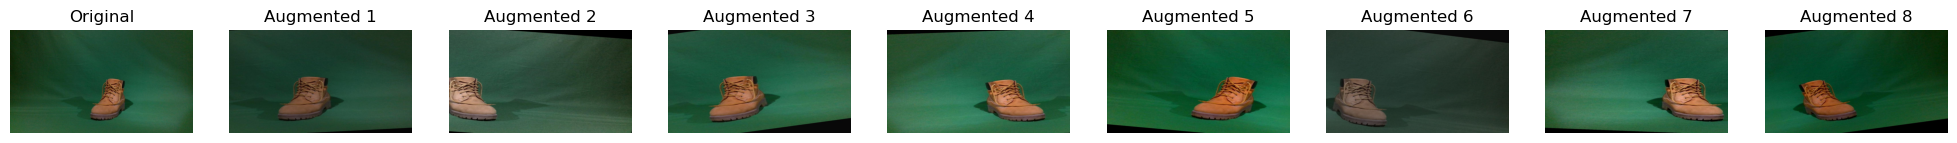

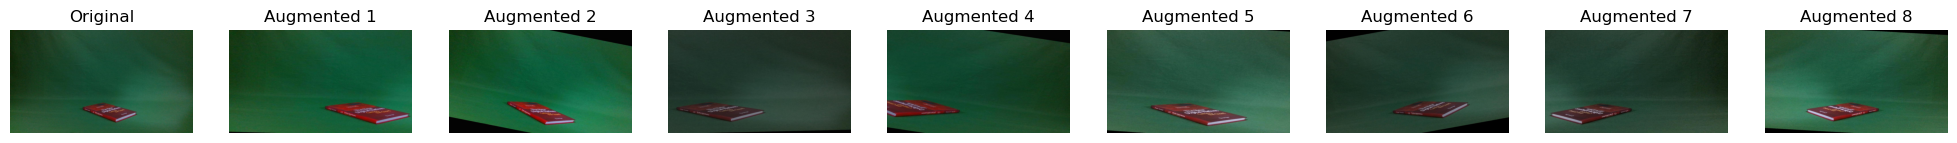

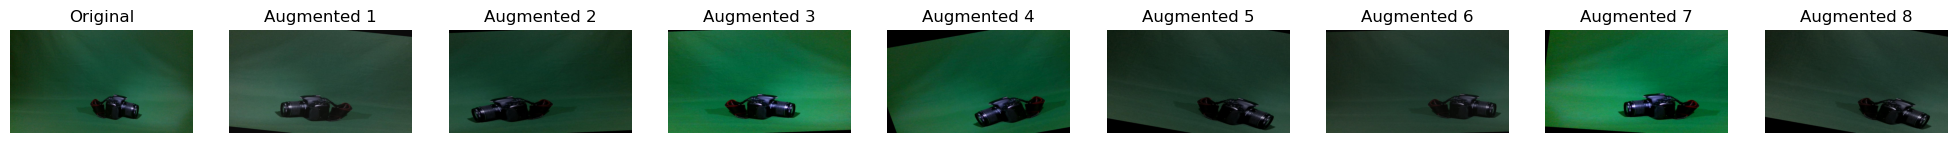

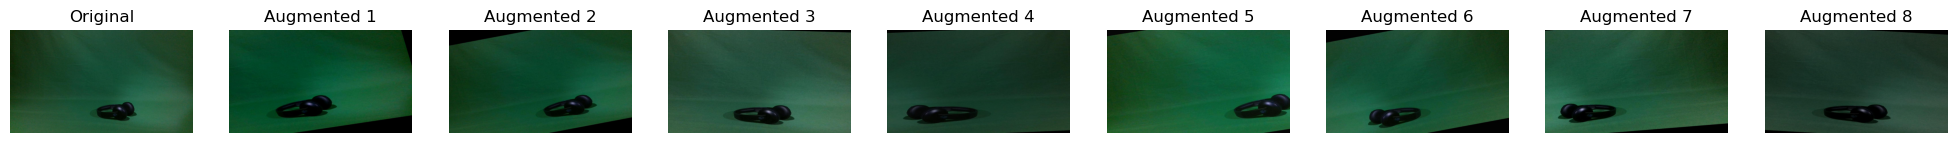

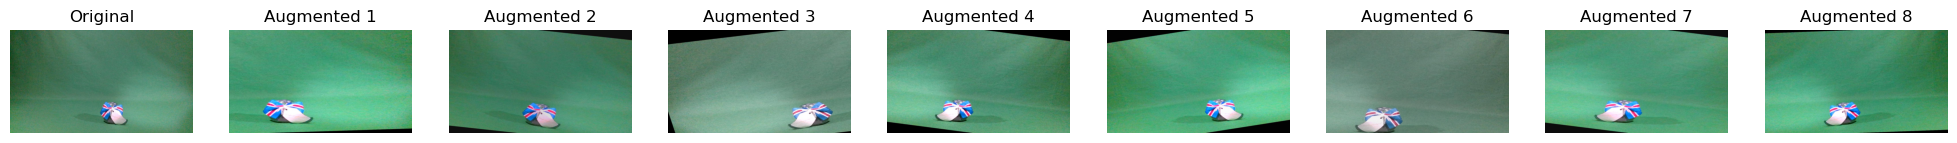

Augmented images successfully saved to c:\Users\koppe\Desktop\University\Artificial Intelligence\Year 2\SEM2\cv\ARI2129-Group-Project-Part-B\Question 3\3. Results\PyTorch
SSIM metrics successfully saved to c:\Users\koppe\Desktop\University\Artificial Intelligence\Year 2\SEM2\cv\ARI2129-Group-Project-Part-B\Question 3\3. Results\PyTorch\0. Metrics\0. ssim_metrics.txt


In [141]:
metrics = []

for filename in os.listdir(cots_dataset_dir):
    img_path = os.path.join(cots_dataset_dir, filename)
    original_image = read_image(img_path)
    
    # Create or clean the directory for each image"s augmented set
    image_dir = os.path.join(results_base_dir, filename.split(".")[0])
    if os.path.exists(image_dir):
        shutil.rmtree(image_dir) # Delete existing content
    os.makedirs(image_dir, exist_ok=True)
    
    # Save the original image
    original_image_path = os.path.join(image_dir, f"1. original_{filename}")
    write_jpeg(original_image, original_image_path)
    
    augmented_images = []
    for i in range(1, 9):
        augmented_image = transforms(original_image)
        ssim_score = calculate_ssim(original_image, augmented_image)
        metrics.append((filename, ssim_score))
        
        # Save the augmented image with the current value of i
        aug_filename = f"{filename.split(".")[0]}_augmented_{i}.jpeg"
        aug_image_path = os.path.join(image_dir, aug_filename)
        write_jpeg(augmented_image, aug_image_path)
        
        augmented_images.append(aug_image_path)
    
    # Plot the original and augmented images
    fig, axes = plt.subplots(1, 9, figsize=(25, 5))
    axes[0].imshow(original_image.permute(1, 2, 0))
    axes[0].set_title("Original")
    axes[0].axis("off")
    
    for j, aug_img_path in enumerate(augmented_images):
        aug_img = read_image(aug_img_path)
        axes[j + 1].imshow(aug_img.permute(1, 2, 0))
        axes[j + 1].set_title(f"Augmented {j+1}")
        axes[j + 1].axis("off")
        
    
    # Save the plot
    plot_path = os.path.join(image_dir, "0. augmentation_cmp.png")
    plt.savefig(plot_path)
    plt.show()
    plt.close(fig)  # Close the figure to release memory
    
# Save SSIM metrics to a file
metrics_file = os.path.join(metrics_dir, "0. ssim_metrics.txt")

# Open the file in write mode
with open(metrics_file, "w") as f:
    previous_filename = None
    augmentation_index = 1
    for filename, ssim_score in metrics:
        # Add a newline when transitioning to a new image
        if previous_filename and filename != previous_filename:
            f.write("\n")
            augmentation_index = 1  # Reset augmentation index for new image
        
        # Construct the augmented filename
        augmented_filename = f"{filename.split(".")[0]}_augmented_{augmentation_index}.jpeg"
        
        # Write the SSIM metric for the current image
        f.write(f"{augmented_filename}: SSIM = {ssim_score:.4f}\n")
        
        previous_filename = filename
        augmentation_index += 1

# Printing a confirmation message (in bold and green)
print(f"\033[1;32mAugmented images successfully saved to {results_base_dir}\033[0m")
print(f"\033[1;32mSSIM metrics successfully saved to {metrics_file}\033[0m")

#### Evaluation 
The same plots were used to visualise the similarity of the augmented images with respect to their original image. The combined use of geometric and photometric transformations seems to have similar results to those used in the TensorFlow implementation, with a slight decrease in the average similarity and a tighter spread with no outliers.

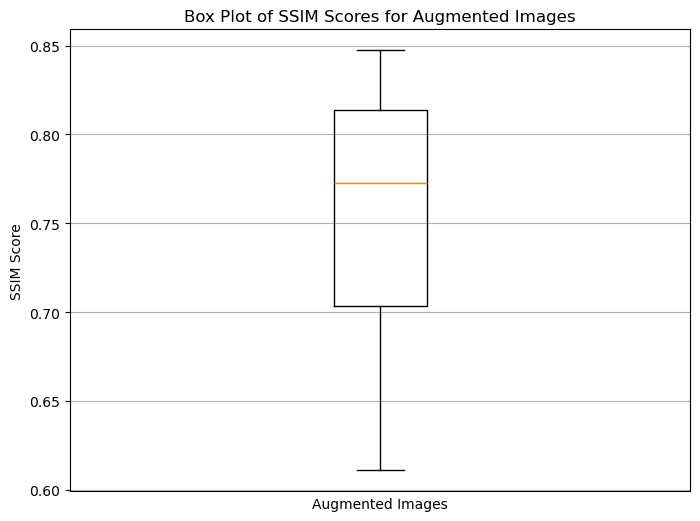

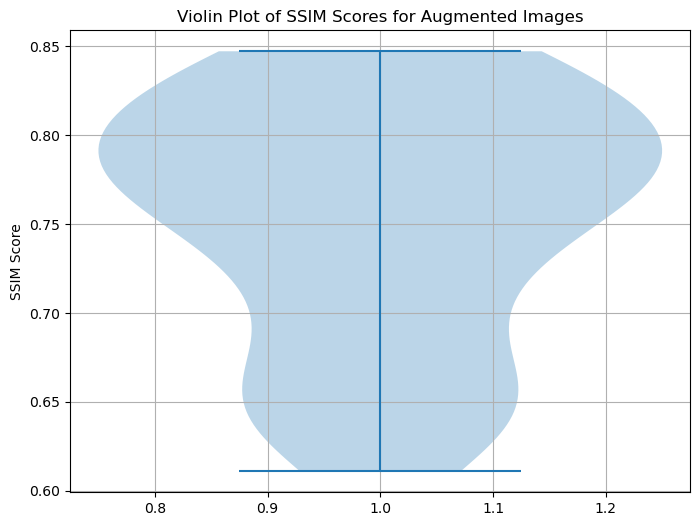

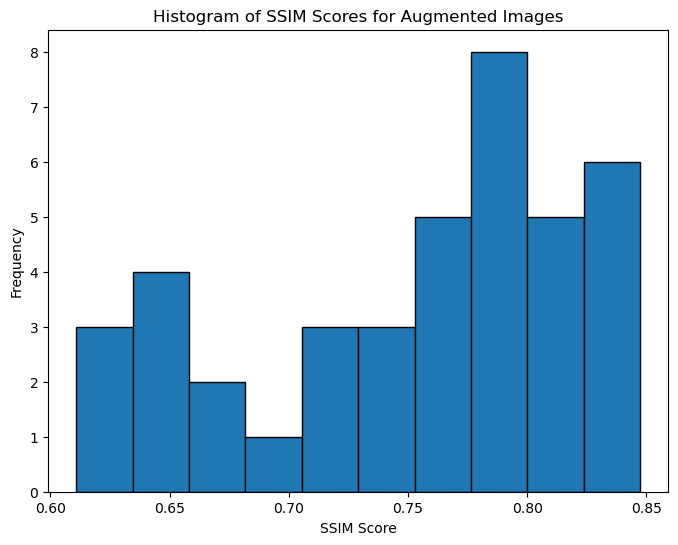

In [142]:
# Load SSIM metrics from the specified file using pandas
metrics_df = pd.read_csv(metrics_file, sep=":", header=None, names=["Filename", "SSIM"])

# Extract numerical part of SSIM scores from the "SSIM" column
metrics_df["SSIM"] = metrics_df["SSIM"].apply(lambda x: float(re.search(r"\d+\.\d+", x).group()))

# Visualize the distribution of SSIM scores using a box plot
plt.figure(figsize=(8, 6))
plt.boxplot(metrics_df["SSIM"])
plt.title("Box Plot of SSIM Scores for Augmented Images")
plt.xlabel("Augmented Images")
plt.ylabel("SSIM Score")
plt.grid(True)
plt.savefig(os.path.join(metrics_dir, "box_plot_ssim.png"))  # Save the box plot
plt.xticks([])
plt.show()

# Visualize the distribution of SSIM scores using a violin plot
plt.figure(figsize=(8, 6))
plt.violinplot(metrics_df["SSIM"])
plt.title("Violin Plot of SSIM Scores for Augmented Images")
plt.ylabel("SSIM Score")
plt.grid(True)
plt.savefig(os.path.join(metrics_dir, "violin_plot_ssim.png"))  # Save the violin plot
plt.show()

# Visualize the distribution of SSIM scores using a histogram
plt.figure(figsize=(8, 6))
plt.hist(metrics_df["SSIM"], bins=10, edgecolor="k")
plt.title("Histogram of SSIM Scores for Augmented Images")
plt.xlabel("SSIM Score")
plt.ylabel("Frequency")
plt.savefig(os.path.join(metrics_dir, "histogram_ssim.png"))  # Save the histogram
plt.show()